In [3]:
# data:
image_dir = "../data/raw/all_images"
label_file = "../data/raw/dental_images.csv"
image_size = (512, 512)
batch_size = 64
validation_split = 0.2
test_split = 0.1
image_type = "photo"
# model:
model_name = "VGG16"
weights = "IMAGENET1K_V1"
num_classes = 4

# training:
epochs = 30
learning_rate = 0.001
save_path = "../outputs/models/"

# evaluation:
metrics = ["accuracy", "precision", "recall", "f1_score"]

# data loading and preprocessing


calculating mean and standard deviation of the data to normalize

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np

# Create a dataset without transformations to calculate the statistics
dataset = ImageDataset(image_dir, label_file, image_type, transform=transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])) 

# Create a DataLoader for batch processing
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize mean and std tensors
mean = torch.zeros(3)
std = torch.zeros(3)

# Iterate through data to calculate mean and std
for images, _ in loader:
    for i in range(3):  # Assuming RGB images
        mean[i] += images[:, i, :, :].mean()
        std[i] += images[:, i, :, :].std()

mean /= len(loader)
std /= len(loader)

print("Mean:", mean)
print("Std:", std)

SyntaxError: invalid syntax (4112037828.py, line 1)

visualizing what data augmentation looks like

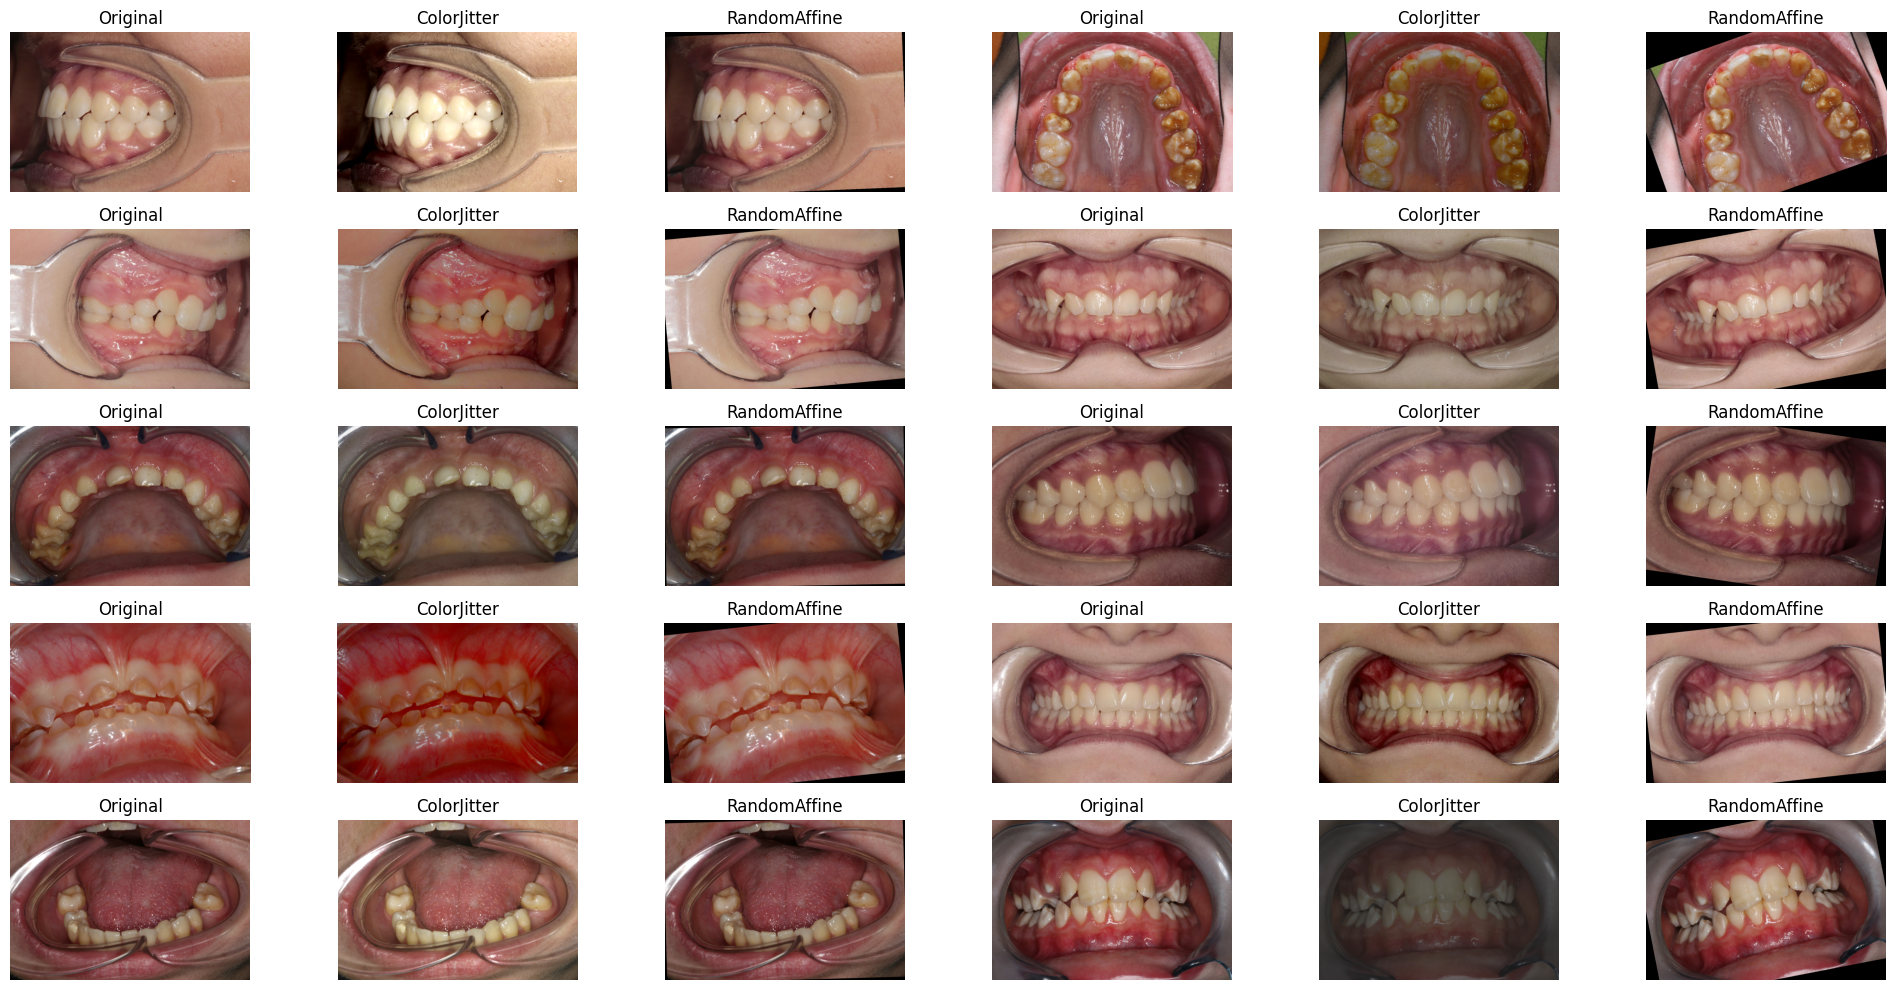

In [41]:
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from torch.utils.data import DataLoader

# Define your transformations
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05)
affine_transform = transforms.RandomRotation(20)

# Load dataset without applying transforms initially
dataset = ImageDataset(image_dir, label_file, image_type, transform=None)

# Select 10 random images
indices = random.sample(range(len(dataset)), 10)

# Plot before and after transformation
plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    # Get image and label
    image, _ = dataset[idx]

    # Apply transformations to PIL image
    jittered_image = color_jitter(image)
    affine_image = affine_transform(image)
    
    # Convert images to numpy for visualization
    image_np = np.array(image)
    jittered_image_np = np.array(jittered_image)
    affine_image_np = np.array(affine_image)
    
    # Display original and transformed images
    plt.subplot(5, 6, 3*i+1)
    plt.imshow(image_np)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(5, 6, 3*i+2)
    plt.imshow(jittered_image_np)
    plt.title('ColorJitter')
    plt.axis('off')
    
    plt.subplot(5, 6, 3*i+3)
    plt.imshow(affine_image_np)
    plt.title('RandomAffine')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, image_type, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            label_file (str): Path to the CSV file with image labels.
            image_type (str): Filter images by type.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file)
        self.labels = self.labels[self.labels['image_type'] == image_type]
        self.labels['label'] = self.labels['category'].astype('category').cat.codes
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx]['file_name'])  # Use column name for clarity
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx]['label']  # Use column name for clarity
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

def load_data():
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),  # Slight color changes
        #transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
        #transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5456, 0.3630, 0.3329], std=[0.1742, 0.1712, 0.1552])
    ])

    dataset = ImageDataset(
        image_dir, 
        label_file,
        image_type,
        transform=transform
    )

    # Splitting indices
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(
        indices, test_size=test_split, stratify=dataset.labels['label'])

    train_idx, val_idx = train_test_split(
        train_idx, test_size=validation_split / (1 - test_split), stratify=dataset.labels.iloc[train_idx]['label'])


 

    # Creating DataLoaders
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# Model creation

In [1]:
import torch.nn as nn
import torchvision.models as models

def get_model(model_name, num_classes, weights=None):
    """
    Initialize and return a model with the specified architecture and weights.

    Args:
        model_name (str): Name of the model architecture to use.
        num_classes (int): Number of output classes.
        weights (str, optional): Pre-trained weights to load.

    Returns:
        nn.Module: The initialized model with the custom classifier.
    """
    if model_name == "VGG16":
        model = models.vgg16(weights=weights)
        for param in model.features.parameters():
            param.requires_grad = False
            #model.classifier[1] = nn.Linear(model.classifier[6].in_features, num_classes)
            #model.classifier[4] = nn.Linear(model.classifier[6].in_features, num_classes)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    # elif model_name == "ResNet18":
    #     model = models.resnet18(weights=weights)
    #     model.fc = nn.Linear(model.fc.in_features, num_classes)
    # elif model_name == "DenseNet121":
    #     model = models.densenet121(weights=weights)
    #     model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    # # Add other models as needed
    # else:
    #     raise ValueError(f"Model {model_name} not supported")
    # Wrap the model with DataParallel
    
    return model


In [5]:
model=get_model(model_name, num_classes, weights)

# training 

In [4]:
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
# from src.model import get_model
# from src.data_loading import load_data
# from src.utils import save_model
# from src.metrics import calculate_metrics

def train_model():
    
    
     # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    accuracies = []
    
    #load data
    train_loader, val_loader, _ = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = get_model(model_name, num_classes, weights)
    # Move model to GPU and wrap with DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        
     # Calculate class weights based on training labels
    train_labels = [label for _, label in train_loader.dataset]
    class_weights = get_class_weights(train_labels)
    
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            #labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # Free GPU memory
            torch.cuda.empty_cache()
            
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
        # # Validation
        # val_metrics = calculate_metrics(model, val_loader, device, criterion)
        # print(f"Validation Metrics: {val_metrics}")
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        # Validation
        model.eval()
        val_metrics = calculate_metrics(model, val_loader, device, criterion)
        print(f"Validation Metrics: {val_metrics}")
        epoch_val_loss = val_metrics.get('loss', float('inf'))  # Set default value if loss is not returned
        val_losses.append(epoch_val_loss)
        accuracies.append(val_metrics['accuracy'])
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader),
        }
        torch.save(checkpoint, save_path + f"_epoch{epoch+1}.pth")
    
    save_model(model, save_path, model_name, image_size, batch_size, epochs, learning_rate)

    # Plotting
    plt.figure(figsize=(12, 5))
    
    epochs_range = range(1, len(train_losses) + 1)  # Ensure x-axis matches length of metrics lists
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(save_path + "_training_metrics.png")
    plt.show()

# evaluation

In [5]:
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
# from src.data_loading import load_data
# from src.utils import load_model
# from src.metrics import calculate_metrics

def evaluate_model():
    _, _, test_loader = load_data()
    model = load_model(
        model_name= model_name, 
        image_size=image_size,  # Replace with actual image size
        batch_size=batch_size, 
        epochs=epochs, 
        learning_rate=learning_rate
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    test_metrics = calculate_metrics(model, test_loader, device)
    print(f"Test Metrics: {test_metrics}")
    
    # Confusion Matrix
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(save_path + "_confusion_matrix.png")
    plt.show()

# metrics

In [6]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(model, dataloader, device, criterion=None):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    if criterion:
        metrics['loss'] = total_loss / len(dataloader)
    
    return metrics


# utils


In [7]:
import torch
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# from src.model import get_model

def save_model(model, path, model_name, image_size, batch_size, epochs, learning_rate):
    # Construct the filename with hyperparameters
    filename = f"{model_name}_img{image_size[0]}x{image_size[1]}_batch{batch_size}_epochs{epochs}_lr{learning_rate:.5f}.pth"
    
    # Combine the base path and the filename
    save_path = os.path.join(path, filename)
    
    # Save the model state dictionary
    torch.save(model.state_dict(), save_path)
    
    print(f"Model saved to: {save_path}")

# def load_model (path):
#     model = get_model("VGG16", 4, True)  # Update this if you have different model or parameters
#     model.load_state_dict(torch.load(path))
#     return model

def load_model(model_name, image_size, batch_size, epochs, learning_rate):
    # Construct the filename from parameters
    filename = f"{model_name}_img{image_size[0]}x{image_size[1]}_batch{batch_size}_epochs{epochs}_lr{learning_rate:.5f}.pth"
    model_path = os.path.join(save_path, filename)
    
    # Ensure that the model file exists
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The model file at {model_path} does not exist.")
    
    model = get_model(model_name, num_classes, weights=None)  # Adjust parameters as needed
     # Load the state dictionary
    state_dict = torch.load(model_path)
    
    # If model was saved using DataParallel, adjust the keys
    if list(state_dict.keys())[0].startswith('module.'):
        # Remove 'module.' from the start of each key
        state_dict = {k[len('module.'):]: v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)    
    return model


# def get_class_weights(labels):
#     class_weights = compute_class_weight(
#         class_weight='balanced', 
#         classes=np.unique(labels), 
#         y=labels
#     )
#     return torch.tensor(class_weights, dtype=torch.float)

def get_class_weights(labels):
    # Convert labels list to a numpy array
    labels = np.array(labels)
    
    # Get the unique classes from the labels
    classes = np.unique(labels)
    print("Classes:", classes)
    print("Labels:", labels)
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=labels
    )
    
    return torch.tensor(class_weights, dtype=torch.float)

# main scipt


Classes: [0 1 2 3]
Labels: [1 3 0 ... 0 1 0]


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/30, Loss: 1.5456678777933122


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Metrics: {'accuracy': 0.39436619718309857, 'precision': 0.318079495755081, 'recall': 0.487107797452625, 'f1_score': 0.2676734776942581, 'loss': 1.0838869015375774}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 2/30, Loss: 0.8419147580862045
Validation Metrics: {'accuracy': 0.5887323943661972, 'precision': 0.5324462574462574, 'recall': 0.5215587993711227, 'f1_score': 0.5236100131752305, 'loss': 0.7337348957856497}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 3/30, Loss: 0.720283043384552
Validation Metrics: {'accuracy': 0.37746478873239436, 'precision': 0.5590763403263403, 'recall': 0.4997068052466582, 'f1_score': 0.3133383984122614, 'loss': 0.8620210289955139}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 4/30, Loss: 0.6624708443880081
Validation Metrics: {'accuracy': 0.6535211267605634, 'precision': 0.6455442815056206, 'recall': 0.5510885128041714, 'f1_score': 0.5013003987594151, 'loss': 0.7597741583983103}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 5/30, Loss: 0.6073296010494232
Validation Metrics: {'accuracy': 0.5154929577464789, 'precision': 0.4431303950284377, 'recall': 0.609508276749656, 'f1_score': 0.4582064680710994, 'loss': 0.6394605537255605}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 6/30, Loss: 0.5160600632429123
Validation Metrics: {'accuracy': 0.5859154929577465, 'precision': 0.6023431544129006, 'recall': 0.5775277680167449, 'f1_score': 0.5483150628276031, 'loss': 0.6775705317656199}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 7/30, Loss: 0.4616172268986702
Validation Metrics: {'accuracy': 0.6450704225352113, 'precision': 0.6639367266168197, 'recall': 0.6364454355833666, 'f1_score': 0.6022341854050367, 'loss': 0.7050720651944479}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 8/30, Loss: 0.4614711210131645
Validation Metrics: {'accuracy': 0.5915492957746479, 'precision': 0.6531451612903225, 'recall': 0.6518929795498478, 'f1_score': 0.562762191164882, 'loss': 0.6370971004168192}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 9/30, Loss: 0.41113719791173936
Validation Metrics: {'accuracy': 0.6112676056338028, 'precision': 0.6689718084285273, 'recall': 0.6449127254525785, 'f1_score': 0.581086951147831, 'loss': 0.936244269212087}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 10/30, Loss: 0.4412019617855549
Validation Metrics: {'accuracy': 0.7436619718309859, 'precision': 0.6211948037466548, 'recall': 0.6235667287250102, 'f1_score': 0.5944367999351259, 'loss': 0.8493221799532572}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 11/30, Loss: 0.4069981090724468
Validation Metrics: {'accuracy': 0.6929577464788732, 'precision': 0.6516641682961066, 'recall': 0.6613458912356595, 'f1_score': 0.6472595725189828, 'loss': 0.6512254079182943}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 12/30, Loss: 0.3944842129945755
Validation Metrics: {'accuracy': 0.7436619718309859, 'precision': 0.6392652950913821, 'recall': 0.627018660427366, 'f1_score': 0.6243864439579182, 'loss': 0.8355277876059214}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 13/30, Loss: 0.35105411261320113
Validation Metrics: {'accuracy': 0.7408450704225352, 'precision': 0.6172238936335404, 'recall': 0.604539080387017, 'f1_score': 0.5877216999553088, 'loss': 1.2394421100616455}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 14/30, Loss: 0.4268320702016354
Validation Metrics: {'accuracy': 0.6929577464788732, 'precision': 0.6470012592219365, 'recall': 0.6301937304339792, 'f1_score': 0.6266990327192372, 'loss': 0.8656165699164072}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 15/30, Loss: 0.3456573985517025
Validation Metrics: {'accuracy': 0.5352112676056338, 'precision': 0.6140526250282348, 'recall': 0.5931965539794822, 'f1_score': 0.5128032593251869, 'loss': 1.0685916145642598}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 16/30, Loss: 0.26213942766189574
Validation Metrics: {'accuracy': 0.7492957746478873, 'precision': 0.6816725690676111, 'recall': 0.6749608952407143, 'f1_score': 0.6767597763499403, 'loss': 1.2521464029947917}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 17/30, Loss: 0.2999248389154673
Validation Metrics: {'accuracy': 0.676056338028169, 'precision': 0.6600090743172504, 'recall': 0.6755345529653048, 'f1_score': 0.644484709245336, 'loss': 0.8005888362725576}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 18/30, Loss: 0.235066282376647
Validation Metrics: {'accuracy': 0.6929577464788732, 'precision': 0.6238079145360591, 'recall': 0.624945653478723, 'f1_score': 0.6189876887203417, 'loss': 0.9110613663991293}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 19/30, Loss: 0.21121902391314507
Validation Metrics: {'accuracy': 0.7605633802816901, 'precision': 0.6335983158976022, 'recall': 0.6328421593684453, 'f1_score': 0.6218164577597437, 'loss': 1.502598116795222}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 20/30, Loss: 0.19436930678784847
Validation Metrics: {'accuracy': 0.6873239436619718, 'precision': 0.6178391317870789, 'recall': 0.6038809200058494, 'f1_score': 0.6045493965255337, 'loss': 1.383142113685608}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 21/30, Loss: 0.18917883560061455
Validation Metrics: {'accuracy': 0.7746478873239436, 'precision': 0.6792866919013708, 'recall': 0.6635305559132579, 'f1_score': 0.6605378583680471, 'loss': 1.117341309785843}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 22/30, Loss: 0.17179805207997562
Validation Metrics: {'accuracy': 0.7408450704225352, 'precision': 0.6801098521375764, 'recall': 0.6583430458642443, 'f1_score': 0.6614163282119939, 'loss': 1.2254414161046345}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 23/30, Loss: 0.16193664604797958
Validation Metrics: {'accuracy': 0.7718309859154929, 'precision': 0.6744112554112555, 'recall': 0.6391749477815051, 'f1_score': 0.626568616014019, 'loss': 1.6720752517382305}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 24/30, Loss: 0.23611813746392726
Validation Metrics: {'accuracy': 0.6957746478873239, 'precision': 0.6615172770790996, 'recall': 0.6721803285963829, 'f1_score': 0.6535484213986534, 'loss': 0.948815236488978}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 25/30, Loss: 0.14699684362858534
Validation Metrics: {'accuracy': 0.7183098591549296, 'precision': 0.6647109863659605, 'recall': 0.6308700790752797, 'f1_score': 0.631720193423057, 'loss': 1.672689437866211}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 26/30, Loss: 0.15982946213334798
Validation Metrics: {'accuracy': 0.5746478873239437, 'precision': 0.6266577562643739, 'recall': 0.6033622090151203, 'f1_score': 0.5487666700195305, 'loss': 1.1546985407670338}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 27/30, Loss: 0.16098698768764735
Validation Metrics: {'accuracy': 0.7352112676056338, 'precision': 0.6868969166866363, 'recall': 0.700653686069175, 'f1_score': 0.6876079180784802, 'loss': 0.9970807731151581}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 28/30, Loss: 0.12171154636889696
Validation Metrics: {'accuracy': 0.6225352112676056, 'precision': 0.6563082274253371, 'recall': 0.6563414278366229, 'f1_score': 0.5975569520837536, 'loss': 1.0939004520575206}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 29/30, Loss: 0.18057966865599157
Validation Metrics: {'accuracy': 0.676056338028169, 'precision': 0.6139960460311447, 'recall': 0.6086276557588033, 'f1_score': 0.6086670549225616, 'loss': 1.084885150194168}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 30/30, Loss: 0.1293397383764386
Validation Metrics: {'accuracy': 0.7323943661971831, 'precision': 0.6772152772534596, 'recall': 0.6260380221940426, 'f1_score': 0.6280587086430156, 'loss': 1.6457688013712566}
Model saved to: ../outputs/models/VGG16_img512x512_batch64_epochs30_lr0.00100.pth


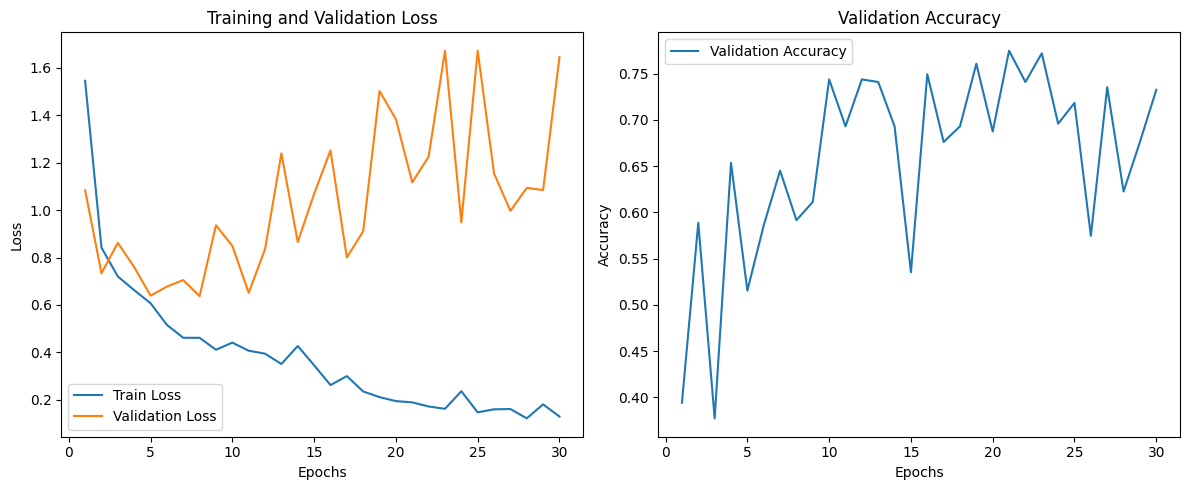

/tmp/ipykernel_213254/1200939961.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Test Metrics: {'accuracy': 0.9044943820224719, 'precision': 0.8895891690009337, 'recall': 0.867650485025628, 'f1_score': 0.8752060873977382}


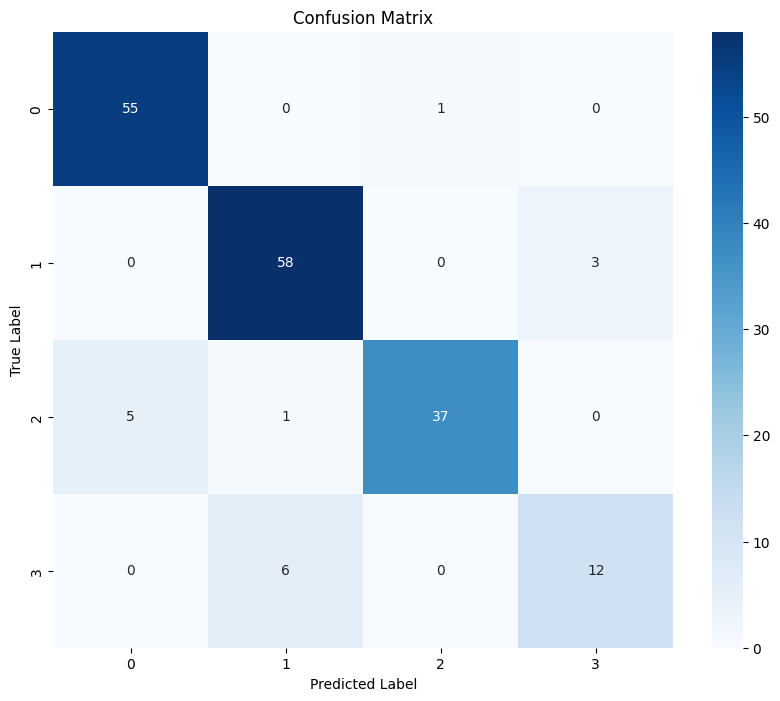

In [8]:
import yaml
# from src.train import train_model
# from src.evaluate import evaluate_model

if __name__ == "__main__":
    #with open('/home/boukhari/projects/dental_image_project/configs/config.yaml', "r") as file:
        #config = yaml.safe_load(file)
    
    train_model()
    evaluate_model()
